# Invalid Tag Modification - v2

## Questions
- Number of changesets flagged total/everyday
- Number of changesets reviewed total/everyday
- Number of changesets harmful total/everyday
- What is the *Hit rate*

---

- Different types of modifications
- Counts for different types of modifications

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

In [3]:
changesets = pd.read_csv('changesets.csv')
changesets.head(2)

,ID,user,editor,Powerfull Editor,comment,source,imagery used,date,reasons,reasons__name,create,modify,delete,bbox,is suspect,harmful,checked,check_user__username,check date
0,47616014,NaN,NaN,False,NaN,NaN,NaN,2017-04-10T09:20:50+00:00,42,Invalid tag modification,NaN,NaN,NaN,NaN,True,NaN,False,NaN,NaN
1,47616001,NaN,NaN,False,NaN,NaN,NaN,2017-04-10T09:20:11+00:00,42,Invalid tag modification,NaN,NaN,NaN,NaN,True,NaN,False,NaN,NaN


In [4]:
# Convert "date" from string to a datetime object.
changesets['date'] = pd.to_datetime(changesets['date'])

In [5]:
# Leave out changesets from the current day which is still incomplete.
import datetime
changesets = changesets[changesets['date'] < datetime.datetime(2017, 4, 10)]

In [6]:
# Check for any duplicate changesets.
print('Before duplicate removal: {}'.format(changesets.shape[0]))
print('After duplicate removal: {}'.format(changesets.drop_duplicates('ID').shape[0]))

Before duplicate removal: 7644
After duplicate removal: 7644


In [7]:
print('Changesets labelled "Invalid tag modification": {}'.format(changesets.shape[0]))

checked_changesets = changesets[changesets['checked'] == True]
print('Changesets checked: {}'.format(checked_changesets.shape[0]))

harmful_changesets = changesets[changesets['harmful'] == True]
print('Changesets harmful: {}'.format(harmful_changesets.shape[0]))

hit_rate = round(100.0 * harmful_changesets.shape[0] / checked_changesets.shape[0], 2)
print('Hit rate: {}%'.format(hit_rate))

Changesets labelled "Invalid tag modification": 7644
Changesets checked: 220
Changesets harmful: 25
Hit rate: 11.36%


In [8]:
counts = changesets.groupby(pd.Grouper(key='date', freq='1d'))['ID'].count()
print('Changesets labelled everyday: {}'.format(round(counts.mean())))

checked_counts = checked_changesets.groupby(pd.Grouper(key='date', freq='1d'))['ID'].count()
print('Changesets checked everyday: {}'.format(round(checked_counts.mean())))

harmful_counts = harmful_changesets.groupby(pd.Grouper(key='date', freq='1d'))['ID'].count()
print('Changesets harmful everyday: {}'.format(round(harmful_counts.mean())))

hit_rate = round(100.0 * harmful_counts.mean() / checked_counts.mean(), 2)
print('Hit rate: {}%'.format(hit_rate))

Changesets labelled everyday: 1274
Changesets checked everyday: 37
Changesets harmful everyday: 4
Hit rate: 11.36%


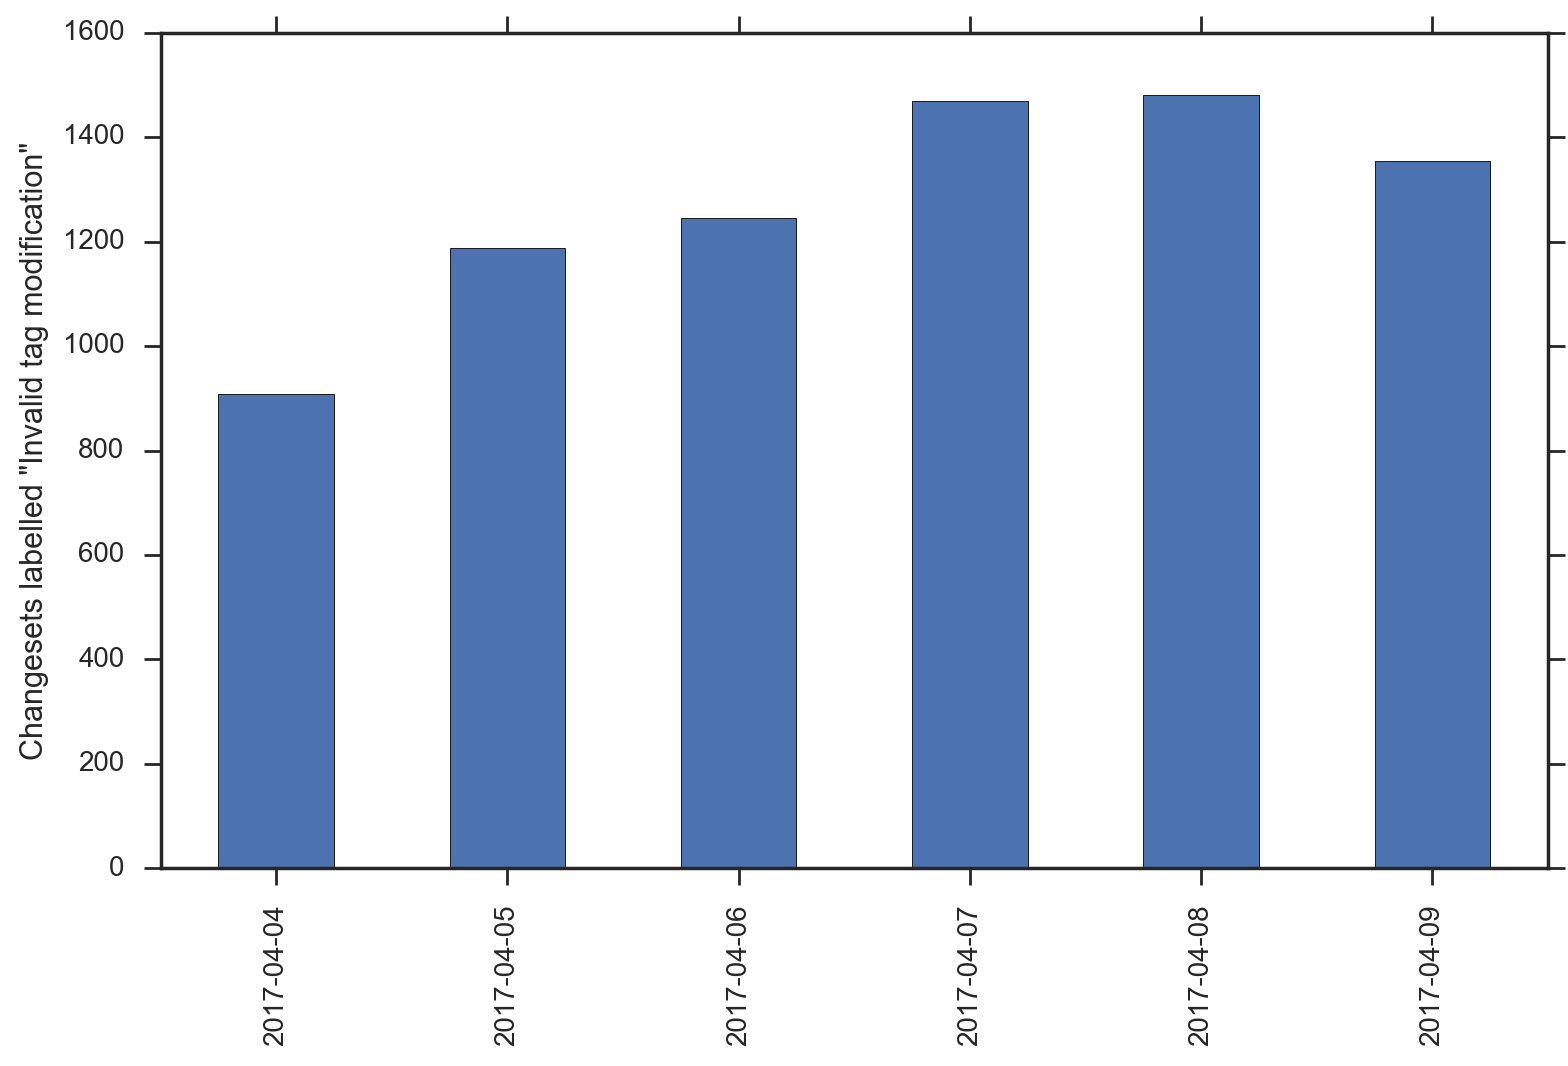

In [9]:
daily_counts = changesets.groupby(pd.Grouper(key='date', freq='1d'))['ID'].count()
ax = daily_counts.plot.bar()
ax.set_xlabel('')
ax.set_xticklabels([str(item) for item in daily_counts.keys().date]);
ax.set_ylabel('Changesets labelled "Invalid tag modification"')
plt.tight_layout()

In [10]:
modifications = pd.read_csv('invalid-tag-modifications-v2.csv')
print(modifications.shape)
modifications.head(5)

(1892, 5)


,changeset_id,harmful,feature_url,added,deleted
0,47622129,True,http://osmcha.mapbox.com/47622129/features/way...,building,landuse
1,47614882,False,http://osmcha.mapbox.com/47614882/features/way...,NaN,building
2,47611562,False,http://osmcha.mapbox.com/47611562/features/nod...,historic,amenity
3,47610141,True,http://osmcha.mapbox.com/47610141/features/nod...,tourism,amenity
4,47609653,False,http://osmcha.mapbox.com/47609653/features/way...,NaN,building


In [11]:
modification_counts = modifications.groupby('deleted')['feature_url'].count()
modification_counts.sort(ascending=False)
modification_counts

deleted
building            879
natural             379
landuse             230
amenity             113
highway             104
leisure              81
waterway             34
shop                 15
sport                15
boundary             14
tourism               7
office                5
public_transport      5
aeroway               5
historic              1
railway               1
emergency             1
Name: feature_url, dtype: int64

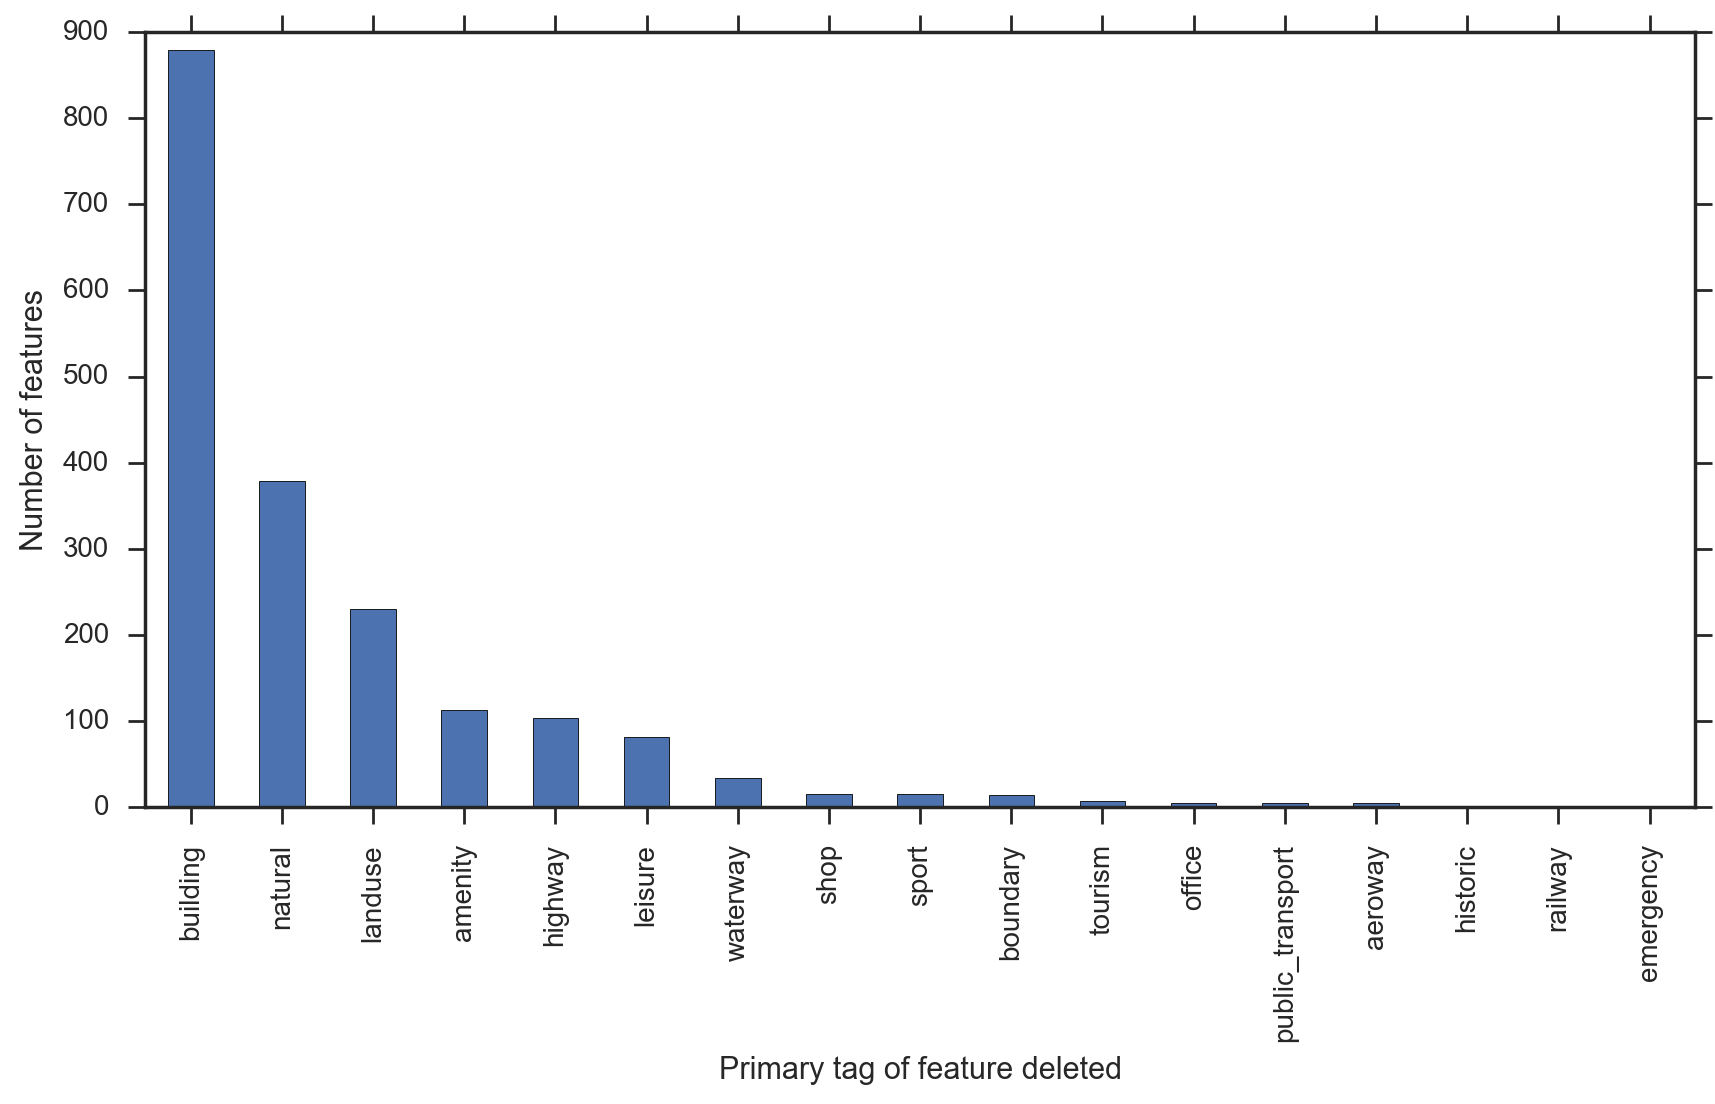

In [12]:
ax = modification_counts.plot.bar(figsize=(10,5))
ax.set_xlabel('Primary tag of feature deleted')
ax.set_ylabel('Number of features')